In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [120]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label
    
  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
      
    out._backward = _backward
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad

    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    
    out._backward = _backward
    return out
    
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out
  
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t,(self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
      
    out._backward = _backward
    return out


  def backward(self):
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(o)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()
    

In [121]:
a = Value(2.0)
a - 1

Value(data=1.0)

In [42]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
  return dot

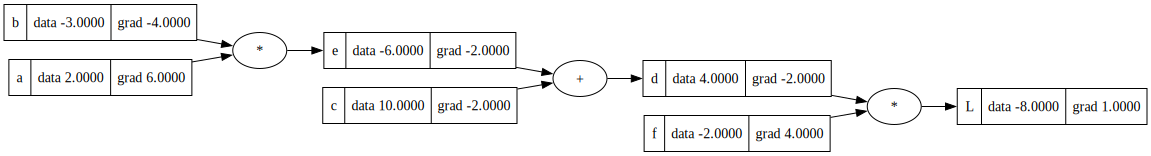

In [55]:
draw_dot(L)

In [56]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

L.grad = 1.0
# L = d * f
# dL/dd = f
# dL/df = d
d.grad = f.data
f.grad = d.data

# how do we do dL/dc
# d = c + e
# dd/dc = 1.0
# dL/dc = dL/dd * dd/dc = f * 1 = f
# we can just directly backpass d's gradient into c and e
# because we are adding the nodes together which ends up 
# becoming 1 for the derivative
c.grad = d.grad
e.grad = d.grad

# dL/da = dL/de * de/da
# de/da = b
# dL/da = f * b
a.grad = e.grad * b.data
b.grad = e.grad * a.data

In [122]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

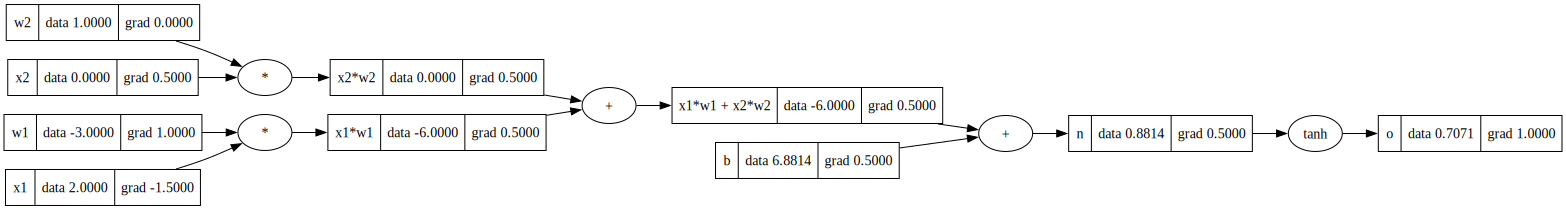

In [125]:
draw_dot(o)

In [124]:
o.backward()

In [101]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)

for node in reversed(topo):
  node._backward()

In [94]:
o.grad = 1.0

o._backward()

n._backward()

x1w1x2w2._backward()

x2w2._backward()
x1w1._backward()

In [75]:
o.grad = 1.0
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1 - o**2
n.grad = 1 - o.data**2

# the layer before n is addition, so we just pass n.grad down
x1w1x2w2.grad = n.grad
b.grad = n.grad
# the layer before x1w1x2w2 is addition, so just pass x1w1x2w2.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

# x2w2 = x2*w2 we have to use chain rule here
# dx2w2/x2 = w2
# dx2w2/w2 = x2
x2.grad = x2w2.grad * w2.data
w2.grad = x2w2.grad * x2.data

x1.grad = x1w1.grad * w1.data
w1.grad = x1w1.grad * x1.data